In [ ]:
inputPath = "/test.PASS"
outputPath = inputPath.replace(".PASS", ".png")
outputPath2 = inputPath.replace(".PASS", "2.PASS")

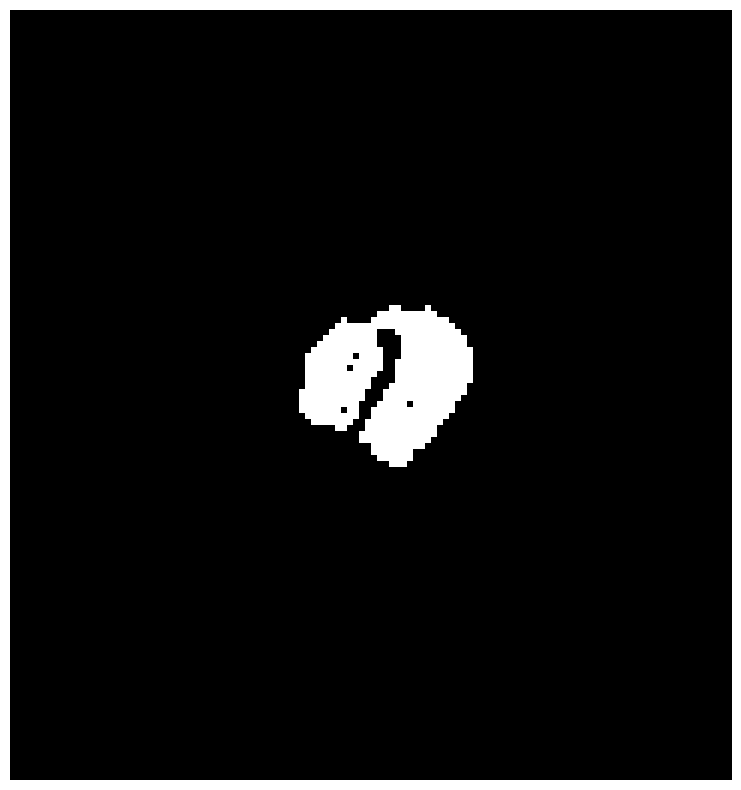

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define 20-byte header from hex
header_hex = [
    0x44, 0x49, 0x52, 0x47, # 'DIRG'
    0x10, 0x00, 0x00, 0x00, # 16 bytes of unknown data
    0x01, 0x00, 0x00, 0x00,
    0x00, 0x08, 0x00, 0x00,
    0x00, 0x08, 0x00, 0x00
]

hexFile = []

with open(inputPath, 'rb') as f:
    byte = f.read(1)
    while byte:
        # Convert byte to a 2-character hex string
        hex_value = format(ord(byte), '02x')
        # Extend the list with the hex value
        hexFile.append(hex_value)
        byte = f.read(1)

# Check the magic
if hexFile[0:4] != [format(x, '02x') for x in header_hex[0:4]]:
    print("Invalid file format")
    exit(1)

# Check the header
for i in range(4, 20):
    if hexFile[i] != format(header_hex[i], '02x'):
        print(f"Different Header! {i}: expected {format(header_hex[i], '02x')}, got {hexFile[i]}")
        exit(1)

# Remove the first 20 bytes (header)
# magic + 16 bytes (unknown)
hexFile = hexFile[4+16:]

bit_array = []

rows = len(hexFile) // 16

for i in range(rows - 1, -1, -1):   
    row = []
    for j in range(15): # 15 as the last byte is end of line marker of some sort
        # Read one byte
        byte = hexFile[i  * 16 + j]
        # Convert it into bits
        bits = format(int(byte, 16), '08b')
        # Reverse the bits
        bits = bits[::-1]
        # Convert the bits to integers
        bits = [int(bit) for bit in bits]
        # Append the bits to the row
        row.extend(bits)
    bit_array.append(row)

# Convert the list to a NumPy array
bit_array = np.array(bit_array)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
# Display the array as an image
ax.imshow(bit_array, cmap='gray', interpolation='nearest')
# Hide the axes
ax.axis('off')
# Show the plot
plt.show()

# Save the image
plt.imsave(outputPath, bit_array, cmap='gray', format='png')

In [5]:
import numpy as np
from PIL import Image

# Load image and convert to grayscale
img = Image.open(outputPath).convert('L')
array = np.array(img)

# Convert to binary (0 or 1)
binary_array = (array > 127).astype(np.uint8)

# Flip vertically (bottom to top)
binary_array = np.flipud(binary_array)

header_bytes = bytes(header_hex)

# Open output file
with open(outputPath2, 'wb') as f:
    # Write the 20-byte header
    f.write(header_bytes)

    for row in binary_array:
        for i in range(0, 120, 8):  # 15 bytes = 120 bits
            bits = row[i:i+8]
            if len(bits) < 8:
                bits = np.pad(bits, (0, 8 - len(bits)), constant_values=0)
            bits_reversed = bits[::-1]
            byte = int(''.join(str(b) for b in bits_reversed), 2)
            f.write(byte.to_bytes(1, 'big'))
        # End-of-line marker (dummy byte)
        f.write(b'\x00')
